# RFM

**RFM** is a method for customer value segmentation based on the level of customer activity and the contribution of transaction amounts. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries. 

RFM stands for the three dimensions:

1. Recency – How recently did the customer purchase? A larger R value indicates that the transaction occurred further in the past, whereas a smaller R value means the transaction occurred more recently.
2. Frequency – How often do they purchase? A larger F value indicates more frequent transactions, implying an active customer, while a smaller F value suggests the customer is less active.
3. Monetary Value – How much do they spend? The amount of money a customer has spent in a recent period. A larger M value indicates a higher customer value, whereas a smaller M value indicates a lower customer value.



In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")


# Load dataset and cleaning

In [2]:
df = pd.read_csv('/Users/yupengshen/DA_portfolio/rfm/rfm_stock_data.csv', encoding='ISO-8859-1')


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df = df.query('Quantity>0 and UnitPrice>0')

In [8]:
df.shape

(530104, 8)

In [9]:
df['InvoiceDate']

0          12/1/2010 8:26
1          12/1/2010 8:26
2          12/1/2010 8:26
3          12/1/2010 8:26
4          12/1/2010 8:26
               ...       
541904    12/9/2011 12:50
541905    12/9/2011 12:50
541906    12/9/2011 12:50
541907    12/9/2011 12:50
541908    12/9/2011 12:50
Name: InvoiceDate, Length: 530104, dtype: object

We only need to keep the date information

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].str.split(' ').str[0])

In [11]:
df['InvoiceDate']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541904   2011-12-09
541905   2011-12-09
541906   2011-12-09
541907   2011-12-09
541908   2011-12-09
Name: InvoiceDate, Length: 530104, dtype: datetime64[ns]

We can only keep the date and disgard the time information

## missing value

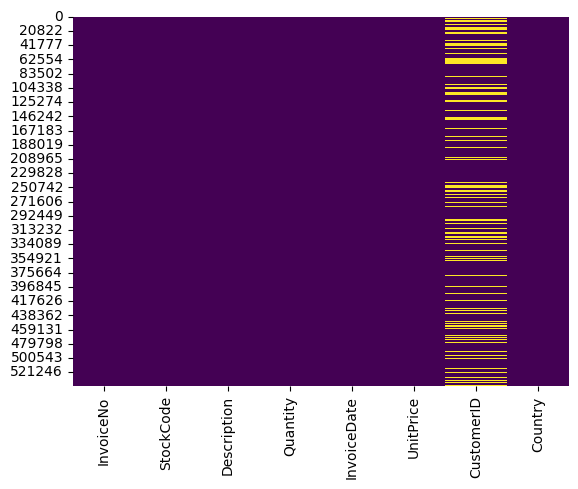

In [12]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [13]:
df[df['CustomerID'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09,10.79,NaN,United Kingdom


In [14]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [15]:
df.isnull().sum().sum()/df.shape[0]

0.24942275478019407

We can remove the data with nan customer id and still perform RFM analysis

In [16]:
df = df.dropna(subset=['CustomerID'], how='all')

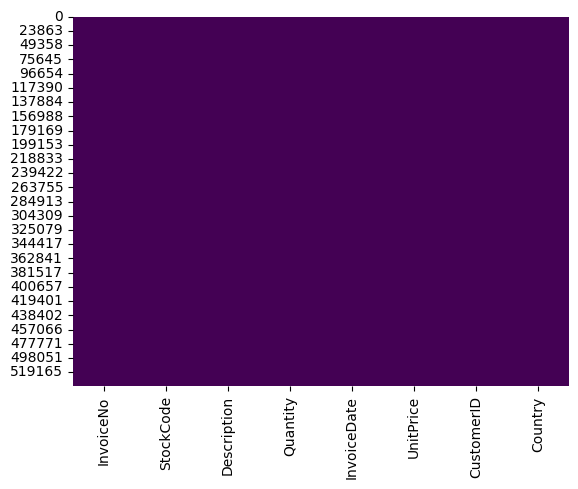

In [17]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

In [18]:
# Adding time information
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['TotalCost'] =  df['UnitPrice'] * df['Quantity']

In [19]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
Year                    int64
Month                   int64
YearMonth           period[M]
TotalCost             float64
dtype: object

In [20]:
rfm = df.pivot_table(
    index='CustomerID',
    values = ["InvoiceNo","TotalCost","InvoiceDate"],
    aggfunc={
        "InvoiceNo": pd.Series.nunique,
        "TotalCost" :"sum",
        "InvoiceDate": "max"
    }
)

In [21]:
rfm.head()

,InvoiceDate,InvoiceNo,TotalCost
CustomerID,,,
12346.0,2011-01-18,1,77183.60
12347.0,2011-12-07,7,4310.00
12348.0,2011-09-25,4,1797.24
12349.0,2011-11-21,1,1757.55
12350.0,2011-02-02,1,334.40


In [22]:
# Taking the last transaction as a base, calculate the Recency for each customer
rfm['Recency'] = (rfm['InvoiceDate'].max() - rfm['InvoiceDate'])/np.timedelta64(1, 'D')

In [23]:
rfm.rename(columns={
        "InvoiceNo": "Frequency",
        "TotalCost": "Monetary"
    }, inplace = True)

In [24]:
rfm.head()

,InvoiceDate,Frequency,Monetary,Recency
CustomerID,,,,
12346.0,2011-01-18,1,77183.60,325.0
12347.0,2011-12-07,7,4310.00,2.0
12348.0,2011-09-25,4,1797.24,75.0
12349.0,2011-11-21,1,1757.55,18.0
12350.0,2011-02-02,1,334.40,310.0


# Analysis

## segmentation by average

In [25]:
#standardization

rfm_standardized = rfm[['Frequency', 'Monetary', 'Recency']].copy()

scaler = StandardScaler()
rfm_standardized[['Frequency', 'Monetary', 'Recency']] = scaler.fit_transform(rfm[['Frequency', 'Monetary', 'Recency']])

Label the customer value and categorize into 8 levels. 

|   | Frequency | Monetary | Recency  |
|----------|----------|----------|----------|
| Above Avergae | 1 | 1 | 1 |
| Below Average | 0 | 0 | 0 |


- "111" - "MVP": These customers buy often, spend the most, and their last purchase was recent. They are your best customers.

- "011" - "Loyal Spenders": They spend a good amount but might not do so very frequently. Their recent purchase activity makes them prime candidates for loyalty programs.

- "101" - "Potential Loyalists": They shop frequently and have shopped recently but haven't spent as much. They have potential to become more valuable if they can be motivated to spend more

- "001" - "Recent Customers": These customers have made a purchase recently but do not yet shop frequently or spend much. They're in the early stages of their relationship with your brand.

- "110" - "Faithful": They shop frequently and spend well but haven’t made purchases recently. Engage them to return.

- "010" - "At Risk": They've spent well in the past but haven’t purchased recently and do so infrequently. They're at risk of churning.

- "100" - "Can't lose them": Frequent shoppers who haven’t made purchases recently and spend less. They need re-engagement.

- "000" - "Hibernating": Customers who infrequently purchase, spend less, and the purchase was not recent. They are the lowest tier of your active customer base.


In [26]:
level=rfm_standardized[['Frequency','Monetary','Recency']].applymap(lambda x:'1'if x>0 else '0') 

In [27]:
result=level['Frequency']+level['Monetary']+level['Recency']
d = {
        "111": "MVP",
        "011": "Loyal Spenders",
        "101": "Potential Loyalists",
        "001": "Recent Customers",
        "110": "Faithful",
        "010": "At Risk",
        "100": "Can't lose them",
        "000": "Hibernating"
    }
rfm_standardized['label']=result.map(d)

In [28]:
rfm_standardized

,Frequency,Monetary,Recency,label
CustomerID,,,,
12346.0,-0.425097,8.358668,2.329388,Loyal Spenders
12347.0,0.354417,0.250966,-0.900588,Faithful
12348.0,-0.035340,-0.028596,-0.170593,Hibernating
12349.0,-0.425097,-0.033012,-0.740589,Hibernating
12350.0,-0.425097,-0.191347,2.179389,Recent Customers
...,...,...,...,...
18280.0,-0.425097,-0.208459,1.849392,Recent Customers
18281.0,-0.425097,-0.219560,0.879399,Recent Customers
18282.0,-0.295178,-0.208742,-0.850588,Hibernating


### Visulize

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [30]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Map labels to colors for visualization
color_map = {
    'MVP': 'red',           
    'Loyal Spenders': 'blue',         
    'Potential Loyalists': 'pink',           
    'Recent Customers': 'yellow',        
    'Faithful': 'purple',        
    'At Risk': 'orange',        
    "Can't lose them": 'deepskyblue',   
    'Hibernating': 'lime'           
}
rfm_standardized['color'] = rfm_standardized['label'].map(color_map)

# Create a 3D scatter plot
fig = go.Figure(layout=dict(width=800, height=700))

# Add traces, one for each segment
for segment, color in color_map.items():
    filtered_rfm = rfm_standardized[rfm_standardized['label'] == segment]
    fig.add_trace(go.Scatter3d(
        x=filtered_rfm['Recency'],
        y=filtered_rfm['Frequency'],
        z=filtered_rfm['Monetary'],
        mode='markers',
        marker=dict(size=5, color=color),
        name=segment  # Legend entry for this segment
    ))

# Set plot layout
fig.update_layout(
    title='RFM Segmentation by Average',
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    ),
    legend_title="RFM"
)

# Show the plot
fig.show()


While we have identified 8 distinct groups in our RFM segmentation, it's important to consider that having 8 groups might sometimes be excessive for practical marketing strategies. These groups, despite being distinct in definition, might not exhibit significant differences in behavior or value, potentially leading to inefficiencies in targeted actions. To refine our approach and ensure more meaningful differentiation among our customer segments, I will employ k-means clustering. This method allows us to analyze the underlying patterns within our data more deeply and group our customers into clusters based on actual behaviors and value metrics. Through k-means clustering, we aim to consolidate overly granular segments into broader, yet more actionable, groups that better reflect the nuances in our customer base, facilitating more targeted and effective marketing strategies.

## K means

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


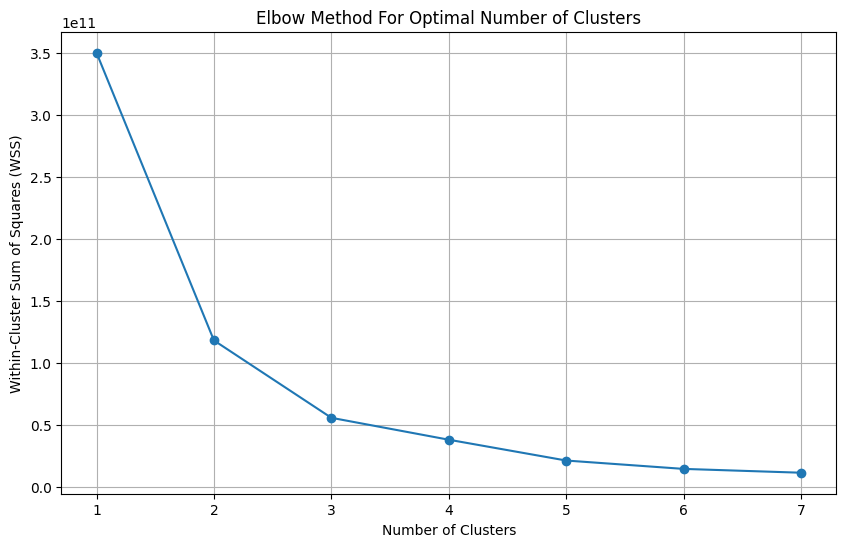

In [31]:
scores = []
range_of_clusters = range(1, 8)
rfm_seg = rfm[['Recency','Frequency','Monetary']].copy()
for k in range_of_clusters:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(rfm_seg)
    scores.append(-kmeans.score(rfm_seg))
    
# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, scores, marker='o', linestyle='-')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.xticks(range_of_clusters)
plt.grid(True)
plt.show()
    
    

Based ont he elbow rule, we select the number of clusters to be 3

In [32]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(rfm_seg)
rfm_seg['cluster'] = kmeans.labels_

In [33]:
rfm_seg.head(10)

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,325.0,1,77183.60,2
12347.0,2.0,7,4310.00,0
12348.0,75.0,4,1797.24,0
12349.0,18.0,1,1757.55,0
12350.0,310.0,1,334.40,0
12352.0,36.0,8,2506.04,0
12353.0,204.0,1,89.00,0
12354.0,232.0,1,1079.40,0
12355.0,214.0,1,459.40,0


Now, let's explore the characteristics of these 3 clusters.

<Axes: xlabel='cluster', ylabel='Frequency'>

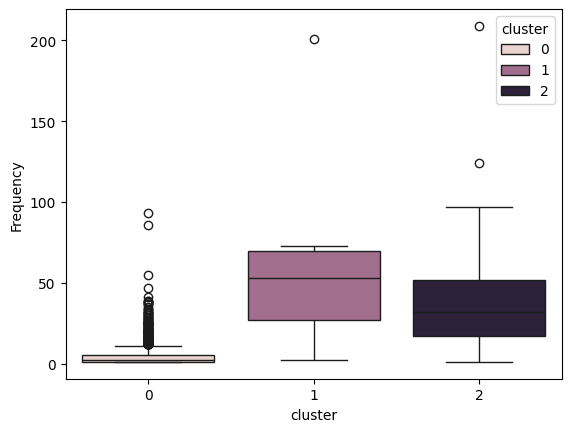

In [34]:
sns.boxplot(x=rfm_seg['cluster'],y=rfm_seg['Frequency'],hue=rfm_seg['cluster'])


<Axes: xlabel='cluster', ylabel='Recency'>

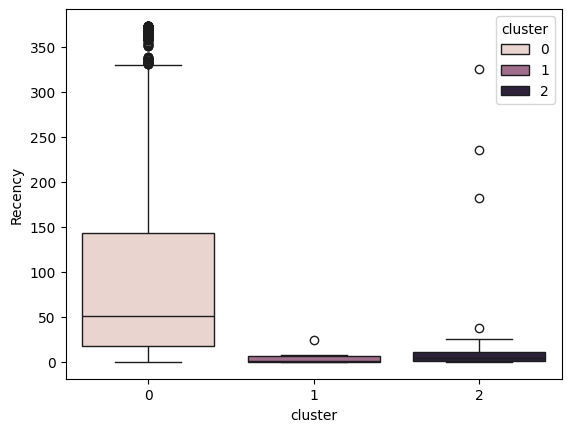

In [35]:
sns.boxplot(x=rfm_seg['cluster'],y=rfm_seg['Recency'],hue=rfm_seg['cluster'])

<Axes: xlabel='cluster', ylabel='Monetary'>

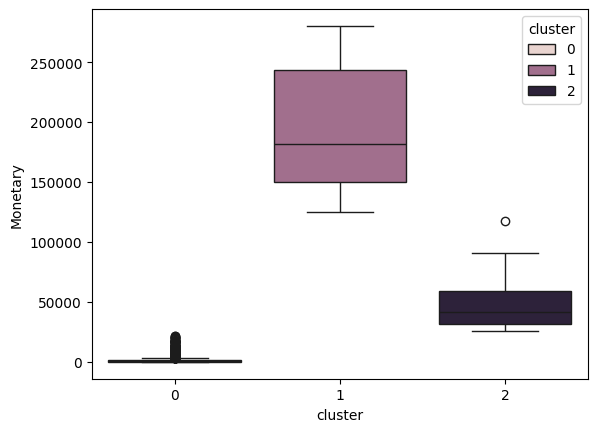

In [36]:
sns.boxplot(x=rfm_seg['cluster'],y=rfm_seg['Monetary'],hue=rfm_seg['cluster'])

### visulize

In [37]:
# Map labels to colors for visualization
color_map = {
    0: 'red',           
    1: 'blue',         
    2: 'lime'         
}
rfm_seg['color'] = rfm_seg['cluster'].map(color_map)

# Create a 3D scatter plot
fig = go.Figure(layout=dict(width=800, height=700))

# Add traces, one for each segment
for segment, color in color_map.items():
    filtered_rfm = rfm_seg[rfm_seg['cluster'] == segment]
    fig.add_trace(go.Scatter3d(
        x=filtered_rfm['Recency'],
        y=filtered_rfm['Frequency'],
        z=filtered_rfm['Monetary'],
        mode='markers',
        marker=dict(size=5, color=color),
        name=segment  # Legend entry for this segment
    ))

# Set plot layout
fig.update_layout(
    title='RFM Segmentation by K means',
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    ),
    legend_title="RFM"
)


- Cluster 1, characterized by the highest values in monetary and frequency along with the lowest in recency, qualifies as a gold customer. 
- Cluster 0, in contrast displaying the lowest frequency and monetary alongside the highest recency, is identified as a bronze customer. 
- Cluster 2 holds the position of a silver customer.

## Quartiles

Quantiles, including quartiles, divide a dataset into equal parts based on their value distribution. In the context of quartiles, the dataset is split into four equal parts:

1. First Segment (1st Quartile): Contains the first 25 values out of 100, representing the lowest 25% of the dataset.

2. Second Segment (2nd Quartile/Median): Contains the next 25 values (26th to 50th), taking us to the 50% mark of the dataset.

3. Third Segment (3rd Quartile): Contains the following 25 values (51st to 75th), which cover up to 75% of the dataset.

4. Fourth Segment: Contains the final 25 values (76th to 100th), representing the top 25% of values in the dataset.



In [38]:
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Frequency,Monetary,Recency
0.25,1.0,307.415,17.00
0.50,2.0,674.485,50.00
0.75,5.0,1661.740,141.75


In [40]:
#Lower the recency, the better.
def RScore(x,Recency,quantile):
    if x <= quantile.loc[0.25]['Recency']:
        return 4
    elif x <= quantile.loc[0.50]['Recency']:
        return 3
    elif x <= quantile.loc[0.75]['Recency']: 
        return 2
    else:
        return 1

In [41]:
# For Monetary and Frequency, the higher, the better

def MFscore(x,M,quantile):
    if x <= quantile.loc[0.25][M]:
        return 1
    elif x <= quantile.loc[0.50][M]:
        return 2
    elif x <= quantile.loc[0.75][M]: 
        return 3
    else:
        return 4


In [42]:
rfm['Recency_Quartile'] = rfm['Recency'].apply(lambda x: RScore(x, 'Recency', quantile))
rfm['Frequency_Quartile'] = rfm['Frequency'].apply(lambda x: MFscore(x, 'Frequency', quantile))
rfm['Monetary_Quartile'] = rfm['Monetary'].apply(lambda x: MFscore(x, 'Monetary', quantile))


In [43]:
rfm.head()

,InvoiceDate,Frequency,Monetary,Recency,Recency_Quartile,Frequency_Quartile,Monetary_Quartile
CustomerID,,,,,,,
12346.0,2011-01-18,1,77183.60,325.0,1,1,4
12347.0,2011-12-07,7,4310.00,2.0,4,4,4
12348.0,2011-09-25,4,1797.24,75.0,2,3,4
12349.0,2011-11-21,1,1757.55,18.0,3,1,4
12350.0,2011-02-02,1,334.40,310.0,1,1,2


In [44]:
# We can merge those Quartile together
rfm['RFMScore'] = rfm['Recency_Quartile'].astype(str) + rfm['Frequency_Quartile'].astype(str) + rfm['Monetary_Quartile'].astype(str)
rfm.head()

,InvoiceDate,Frequency,Monetary,Recency,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,2011-01-18,1,77183.60,325.0,1,1,4,114
12347.0,2011-12-07,7,4310.00,2.0,4,4,4,444
12348.0,2011-09-25,4,1797.24,75.0,2,3,4,234
12349.0,2011-11-21,1,1757.55,18.0,3,1,4,314
12350.0,2011-02-02,1,334.40,310.0,1,1,2,112


We can also add those quartile scores into a single composite score (eg, 4+1+1), which would vary from 3 to 12. However, a potential drawback of this approach is that it assigns equal weight to each quantile. Different companies might prioritize these three metrics differently, affecting how they interpret the significance of each.

In [45]:
rfm['Total_score'] = rfm['Recency_Quartile'] + rfm['Frequency_Quartile']+rfm['Monetary_Quartile']

In [46]:
rfm.head()

,InvoiceDate,Frequency,Monetary,Recency,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12346.0,2011-01-18,1,77183.60,325.0,1,1,4,114,6
12347.0,2011-12-07,7,4310.00,2.0,4,4,4,444,12
12348.0,2011-09-25,4,1797.24,75.0,2,3,4,234,9
12349.0,2011-11-21,1,1757.55,18.0,3,1,4,314,8
12350.0,2011-02-02,1,334.40,310.0,1,1,2,112,4


### By total_score

<Axes: title={'center': 'Recency'}, xlabel='Total_score'>

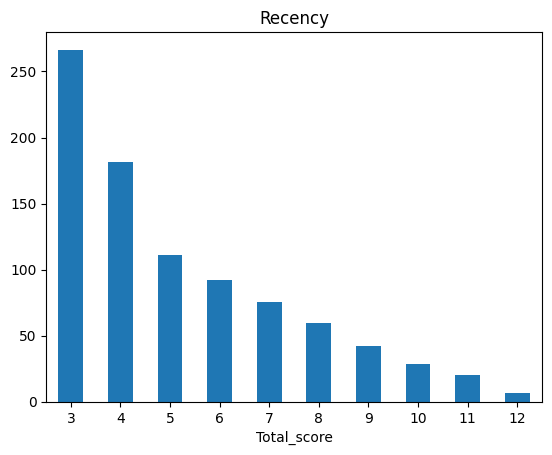

In [47]:
rfm.groupby('Total_score')['Recency'].mean().plot(kind='bar',rot=0,title='Recency')

<Axes: title={'center': 'Frequency'}, xlabel='Total_score'>

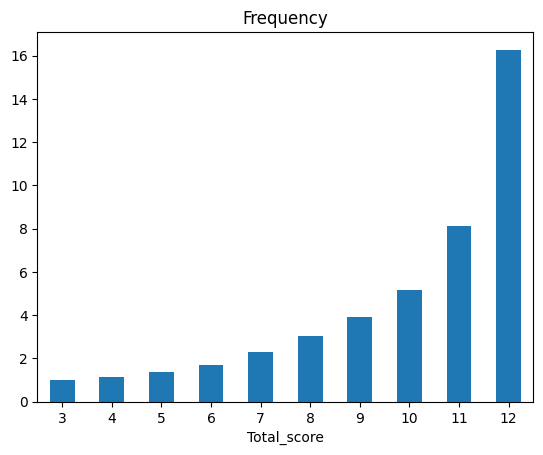

In [48]:
rfm.groupby('Total_score')['Frequency'].mean().plot(kind='bar',rot=0,title='Frequency')

<Axes: title={'center': 'Monetary'}, xlabel='Total_score'>

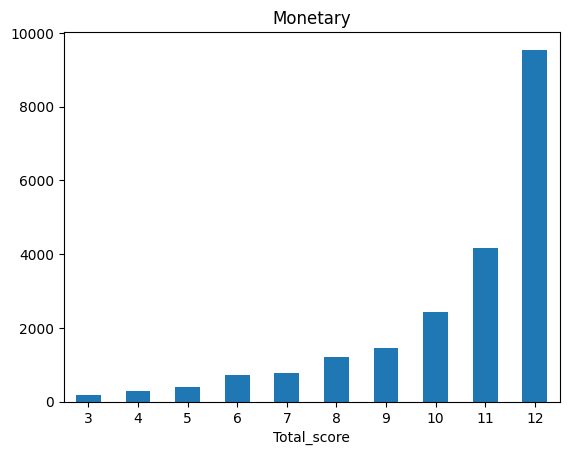

In [49]:
rfm.groupby('Total_score')['Monetary'].mean().plot(kind='bar',rot=0,title='Monetary')

### By rfm score

In [51]:
rfm.groupby('RFMScore')['Monetary'].mean().sort_values(ascending=False)

RFMScore
424    30112.860000
444     9547.540000
114     8910.267273
134     7034.239444
344     5723.566257
           ...     
311      175.388639
211      174.711058
411      170.120492
111      165.206036
141       70.020000
Name: Monetary, Length: 61, dtype: float64

In [52]:
rfm.groupby('RFMScore')['Frequency'].mean().sort_values(ascending=False)

RFMScore
444    16.274123
144    11.600000
344    10.187166
244     8.057143
343     7.468085
         ...    
213     1.000000
212     1.000000
211     1.000000
114     1.000000
111     1.000000
Name: Frequency, Length: 61, dtype: float64

In [54]:
rfm.groupby('RFMScore')['Recency'].mean().sort_values(ascending=True)

RFMScore
414      2.000000
442      6.500000
444      6.721491
424      7.166667
434      7.761364
          ...    
113    252.615385
112    259.666667
142    262.000000
111    266.596847
114    267.727273
Name: Recency, Length: 61, dtype: float64

In [55]:
rfm.head()

,InvoiceDate,Frequency,Monetary,Recency,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12346.0,2011-01-18,1,77183.60,325.0,1,1,4,114,6
12347.0,2011-12-07,7,4310.00,2.0,4,4,4,444,12
12348.0,2011-09-25,4,1797.24,75.0,2,3,4,234,9
12349.0,2011-11-21,1,1757.55,18.0,3,1,4,314,8
12350.0,2011-02-02,1,334.40,310.0,1,1,2,112,4


In [57]:
rfm.columns

Index(['InvoiceDate', 'Frequency', 'Monetary', 'Recency', 'Recency_Quartile',
       'Frequency_Quartile', 'Monetary_Quartile', 'RFMScore', 'Total_score'],
      dtype='object')

In [58]:
# Select the columns you want to standardize
columns_to_standardize = ['Frequency', 'Monetary', 'Recency']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the selected columns and transform the data
rfm[columns_to_standardize] = scaler.fit_transform(rfm[columns_to_standardize])

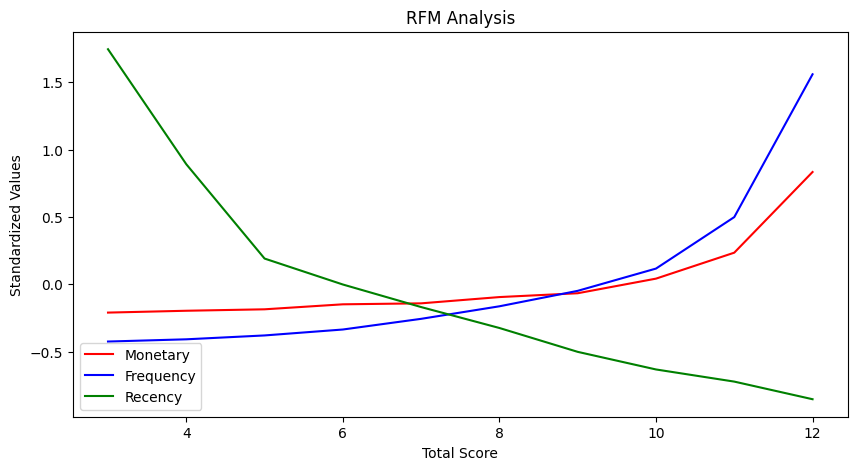

In [67]:
m = rfm.groupby('Total_score')['Monetary'].mean()
f = rfm.groupby('Total_score')['Frequency'].mean()
r = rfm.groupby('Total_score')['Recency'].mean()


# Plot mean values of Monetary, Frequency, and Recency on the same set of axes
plt.figure(figsize=[10, 5])

# Plot Monetary
plt.plot(m.index, m.values, color='red', label='Monetary')

# Plot Frequency
plt.plot(f.index, f.values, color='blue', label='Frequency')

# Plot Recency
plt.plot(r.index, r.values, color='green', label='Recency')

plt.title('RFM Analysis')
plt.xlabel('Total Score')
plt.ylabel('Standardized Values')
plt.legend()

plt.show()

- The **Monetary** value, shown in red, has a gentle upward trend on the graph. This tells us that as customers spend more money, their total score tends to go up. Even small increases in spending can lead to a noticeable rise in the score, emphasizing the strong influence of monetary value on the overall score.

- The **Frequency** of purchases, illustrated by the blue line, shows a steeper increase. This means that customers need to shop more often to see a significant impact on their score. The steepness indicates that while frequency is crucial, it requires more substantial changes in shopping habits to affect the score in the same way monetary value does.

- For the **Recency** of purchases, The green line, which represents how recently customers have made purchases, starts with a sharp descent for lower total scores, indicating that at this stage, even purchases that are slightly more recent can result in a considerable increase in the total score. As we progress towards higher scores, the line's decline becomes more gradual. This shift means that at higher levels of the total score, small improvements in the recency of purchases—making them even more recent—have a larger effect on the total score. The gentler slope at higher scores indicates a higher sensitivity of the total score to changes in recency: a small step towards more recent activity can lead to a substantial increase in the total score.